# CNN model

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import datetime
import random
import shutil
from functools import partial
from pathlib import Path

# Third party imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Local imports
import configuration as config

wavelengths = 283
sample_size = 100

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Data preparation

### 1.1. Load planet list

In [2]:
# Load corrected/extracted data for a sample planet
with h5py.File(f'{config.PROCESSED_DATA_DIRECTORY}/train.h5', 'r') as hdf:
    planet_ids = list(hdf.keys())

print(f'Found {len(planet_ids)} planets in training data.')

Found 1100 planets in training data.


### 1.2. Split planets into training & validation

In [3]:
random.shuffle(planet_ids)

training_planet_ids = planet_ids[:len(planet_ids) // 2]
validation_planet_ids = planet_ids[len(planet_ids) // 2:]

print(f'Training planets: {len(training_planet_ids)}')
print(f'Validation planets: {len(validation_planet_ids)}')

Training planets: 550
Validation planets: 550


## 2. Data generator

### 2.1. Data loader function

In [4]:
def data_loader(planet_ids: list, data_file: str, sample_size: int = 100):
    '''Generator that yields signal, spectrum pairs for training/validation/testing.

    Args:
        planet_ids (list): List of planet IDs to include in the generator.
        data_file (str): Path to the HDF5 file containing the data.
        sample_size (int, optional): Number of frames to draw from each planet. Defaults to 100.
    '''

    with h5py.File(data_file, 'r') as hdf:

        while True:
            np.random.shuffle(planet_ids)
            
            for planet_id in planet_ids:

                signal = hdf[planet_id]['signal'][:]
                spectrum = hdf[planet_id]['spectrum'][:]

                indices = random.sample(range(signal.shape[0]), sample_size)
                sample = signal[sorted(indices), :]

                yield sample, spectrum


### 2.2. Prefill the arguments to `data_loader()`

In [5]:
training_data_generator = partial(
    data_loader,
    planet_ids=training_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=config.SAMPLES
)

validation_data_generator = partial(
    data_loader,
    planet_ids=validation_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=config.SAMPLES
)

### 2.3. Create TF datasets

In [6]:
training_dataset = tf.data.Dataset.from_generator(
    training_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, wavelengths), dtype=tf.float64),
        tf.TensorSpec(shape=(wavelengths), dtype=tf.float64)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    validation_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, wavelengths), dtype=tf.float64),
        tf.TensorSpec(shape=(wavelengths), dtype=tf.float64)
    )
)

2025-09-18 07:13:58.622703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10774 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2025-09-18 07:13:58.623847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10774 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7


## 3. CNN

### 3.1. Model definition

In [7]:
def compile_model(
        samples: int=config.SAMPLES,
        wavelengths: int=config.WAVELENGTHS,
        learning_rate: float=config.LEARNING_RATE,
        l1: float=config.L1_PENALTY,
        l2: float=config.L2_PENALTY,
        filter_nums=config.FILTER_NUMS,
        filter_size=config.FILTER_SIZE
) -> tf.keras.Model:

    '''Builds the convolutional neural network regression model'''

    # Set-up the L1L2 for the dense layers
    regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    model = tf.keras.Sequential([
        tf.keras.layers.Input((samples,wavelengths,1)),
        tf.keras.layers.Conv2D(
            filter_nums[0],
            filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[1],
            filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[2],
            filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            128,
            kernel_regularizer=regularizer,
            activation='relu',
        ),
        tf.keras.layers.Dense(wavelengths, activation='relu')
    ])

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra
    # metrics to evaluate
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(name='MSE'),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )

    return model

In [8]:
model = compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 283, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 141, 32)      0         
 )                                                               
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 283, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 141, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 141, 64)       18496     
                                                        

### 3.2. Callbacks

In [9]:
# Deal with tensorboard log directory
try:
    shutil.rmtree(f'{config.TENSORBOARD_LOG_DIR}')
except FileNotFoundError:
    pass

Path(config.TENSORBOARD_LOG_DIR).mkdir(parents=True, exist_ok=True)

# Set tensorboard callback
log_dir = config.TENSORBOARD_LOG_DIR + f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.000005,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

In [ ]:
%%time

training_results = model.fit(
  training_dataset.batch(config.BATCH_SIZE),
  validation_data=validation_dataset.batch(config.BATCH_SIZE),
  epochs=config.EPOCHS,
  steps_per_epoch=config.STEPS,
  validation_steps=config.STEPS,
  verbose=1
)

print()

Epoch 1/20


50/50 [==============================] - 16s 321ms/step - loss: 1.3013e-04 - RMSE: 0.0114 - val_loss: 1.1878e-04 - val_RMSE: 0.0109
Epoch 2/20
50/50 [==============================] - 16s 317ms/step - loss: 1.2843e-04 - RMSE: 0.0113 - val_loss: 1.1522e-04 - val_RMSE: 0.0107
Epoch 3/20
50/50 [==============================] - 16s 330ms/step - loss: 1.2258e-04 - RMSE: 0.0111 - val_loss: 1.1386e-04 - val_RMSE: 0.0107
Epoch 4/20
50/50 [==============================] - 17s 344ms/step - loss: 1.2696e-04 - RMSE: 0.0113 - val_loss: 1.1125e-04 - val_RMSE: 0.0105
Epoch 5/20
50/50 [==============================] - 18s 372ms/step - loss: 1.2279e-04 - RMSE: 0.0111 - val_loss: 1.0791e-04 - val_RMSE: 0.0104
Epoch 6/20
50/50 [==============================] - 16s 325ms/step - loss: 1.3147e-04 - RMSE: 0.0115 - val_loss: 1.0918e-04 - val_RMSE: 0.0104
Epoch 7/20
50/50 [==============================] - 16s 325ms/step - loss: 1.1880e-04 - RMSE: 0.0109 - val_loss: 1.1121e-04 - val_RMSE: 0.0105
Epoch 8/20

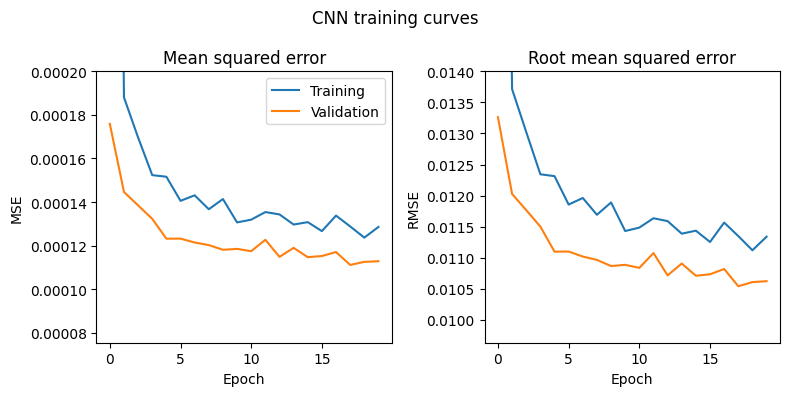

In [14]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation MSE
axs[0].set_title('Mean squared error')
axs[0].plot(np.array(training_results.history['loss']), label='Training')
axs[0].plot(np.array(training_results.history['val_loss']), label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')
axs[0].set_ylim(top=2e-4)
# axs[0].set_yscale('log')
axs[0].legend(loc='upper right')

# Plot training and validation binary cross-entropy
axs[1].set_title('Root mean squared error')
axs[1].plot(training_results.history['RMSE'])
axs[1].plot(training_results.history['val_RMSE'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('RMSE')
axs[1].set_ylim(top=0.014)
# axs[1].set_yscale('log')

# Show the plot
fig.tight_layout()